In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
# import jax.numpy as jnp
# import jax

plt.rcParams.update({'font.size': 14})
%config InlineBackend.figure_format = 'retina'

# Conjugate gradients

1. (3) Метод сопряженных градиентов (CG)

    (Можно прислать рукописное решение)
    
    CG является оптимальным (по определению) методом первого порядка для поиска минимума квадратичных функций: 
    $$f(x) = \frac{1}{2}x^\top A x - b^\top x \rightarrow \min_x.$$ 
    Обозначим $\delta^k = x^{k+1} - x^{k}$.
    Пользуясь тем, что направления шагов, генерируемые CG, сопряжены (Лемма 1.3.3 в Нестерове)
    $$\forall i \neq j :~ \langle A \delta^i, \delta^j \rangle = 0,$$
    
    получите выражения для коэффициентов $h^k, \beta^k$ в следующей форме записи CG:
    
    $$\delta^k = -h^k\left(f'(x^k) - \beta^k \delta^{k-1} \right), ~k>0 $$
    (первый шаг делается по антиградиенту).
    
    Указание: методы первого порядка находят приближенные решения $x^k$ в подпространстве 
    $$x^0 + \texttt{Lin}\left\{f'(x^0), \ldots, f'(x^{k-1})\right\} = 
        x^0 + \texttt{Lin}\left\{\delta^0, \ldots, \delta^{k-1}\right\}.
    $$
    Записав это утверждение в виде линейной комбинации с неизвестными коэффициентами $\delta^k = -h^k f'(x^k) + \sum \lambda^i \delta^i$, покажите, что коэффициенты при $\delta^i,~i<k-1$ равны нулю, и найдите $\beta^k$. 
    Найдите $h^k$ как решение задачи одномерной минимизации для полученного направления.

# Accelerated Gradient Method
Задача [логистической регрессии](http://www.machinelearning.ru/wiki/index.php?title=%D0%9B%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F) c $l_2$ регуляризацией
для бинарной классификации имеет вид

$$
f(w) = \frac12 \|w\|_2^2 + C \frac1m \sum_{i=1}^m \log (1 + \exp(- y_i \langle x_i, w \rangle)) \to \min_w
$$

где $w$-вектор параметров модели, $x_i$ - вектор признаков $i$-го объекта, $y_i \in \{-1, 1 \}$ - метка класса $i$-го объекта 



2. (2.5) Оцените константы гладкости и выпуклости для этой задачи (для подбора оптимальных параметров методов оптимизации). 

3. (2) Реализуйте ускоренный градиентный метод Нестерова (AGM) для этой задачи. Постройте на одном графике графики сходимости (по норме градиента) метода градиентного спуска (GD) (с адаптивным подбором шага или постоянным шагом, на Ваш вкус) и метода Нестерова для этой задачи.

4. (3) Запустите методы AGM и GD, варьируя параметр $C$ в диапазоне нескольких порядков. По экспериментальным данным определите для обоих методов зависимость скорости сходимости от числа обусловленности $\chi = \frac L \mu$. Конкретнее, определите степень $\alpha$, с которой $\chi$ входит под экспоненту: $\varepsilon(k) \leq O(\exp(-c \chi^\alpha k))$. Сравните результат с теорией.



- Для генерации данных можно использовать [эту](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) функцию

In [2]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=100, n_features=20, n_informative=2, n_redundant=2, random_state=42
)
y[y==0] = -1


In [3]:
def f(w, X, y, C):
    n = X.shape[0]
    return 1/2*(w@w) + C/n * np.sum(np.log(np.ones(len(y)) + np.exp(-y*(X@w))))

def grad_f(w, X, y, C):
    n = X.shape[0]
    return w + C/n * np.sum( -(X.T*y)*(np.exp(-y*(X@w))/ (1+np.exp(-y*(X@w)))) , axis=1)

def func(w) :
    return f(w,X,y,C)
def grad_func(w):
    return grad_f(w,X,y,C)

In [4]:
w = np.ones(len(X[0]))/10
C = 0.1
eps = w/1000
# Check grad
print("df/dw @w =" , grad_f(w,X,y,C)@ )
print("df/dw @w =" , (f(w + eps, X, y, C) - f(w, X, y, C)) )


SyntaxError: invalid syntax (1754127842.py, line 5)

In [5]:
def gd_const_step(func, grad_func, x_init, max_iter=100, eps=1e-8):
    x = x_init
    f = func(x)
    grad = grad_func(x)
    num_iters = 0
    step_size = 2/(L+1)
    x_array = []
    f_array = []
    grad_array = []
    # while np.linalg.norm(grad , ord = 2) > eps and num_iters < max_iter:
    while num_iters < max_iter:
        x_new = x - step_size * grad
        f_new = func(x_new)
        x = x_new
        f = f_new
        x_array.append(x)
        f_array.append(f)
        grad_array.append(np.linalg.norm(grad , ord = 2))
        grad = grad_func(x)
        num_iters += 1
    
    return x_array, f_array , grad_array



def gd_nesterov(func, grad_func, x_init, max_iter=15000 , eps = 1e-8):
    x = x_init
    y = x
    num_iters = 0
    x_array = []
    f_array = []
    grad_array = []
    while num_iters < max_iter :
        grad = grad_func(y)
        x_new = y - 1/L*grad 
        y_new = x_new + (np.sqrt(L) - 1)/(np.sqrt(L) + 1) * (x_new - x) 
        x = x_new
        y = y_new
        x_array.append(x)
        f_array.append(func(x))
        grad_array.append(np.linalg.norm(grad , ord = 2))
        if grad_array[-1] <eps :
            break
        num_iters += 1

    return x_array, f_array , grad_array

Запустим ускоренный метод Нестерова для произвольной константы C = 100.

Для L мы знаем точное значение $\lambda_{max}(I + \frac{C}{4m}X^TX)$, так как в диагональных элементах $\Sigma$ у гессиана $I + \frac{C}{m}X^T\Sigma X$ находятся функции вида $\sigma(x)(1-\sigma (x)) \le 1/4$, достигающие равенства 1/4 в точке x = 0, которая в свою очередь достигается при w = 0 $(x = y_i<x_i,w>)$

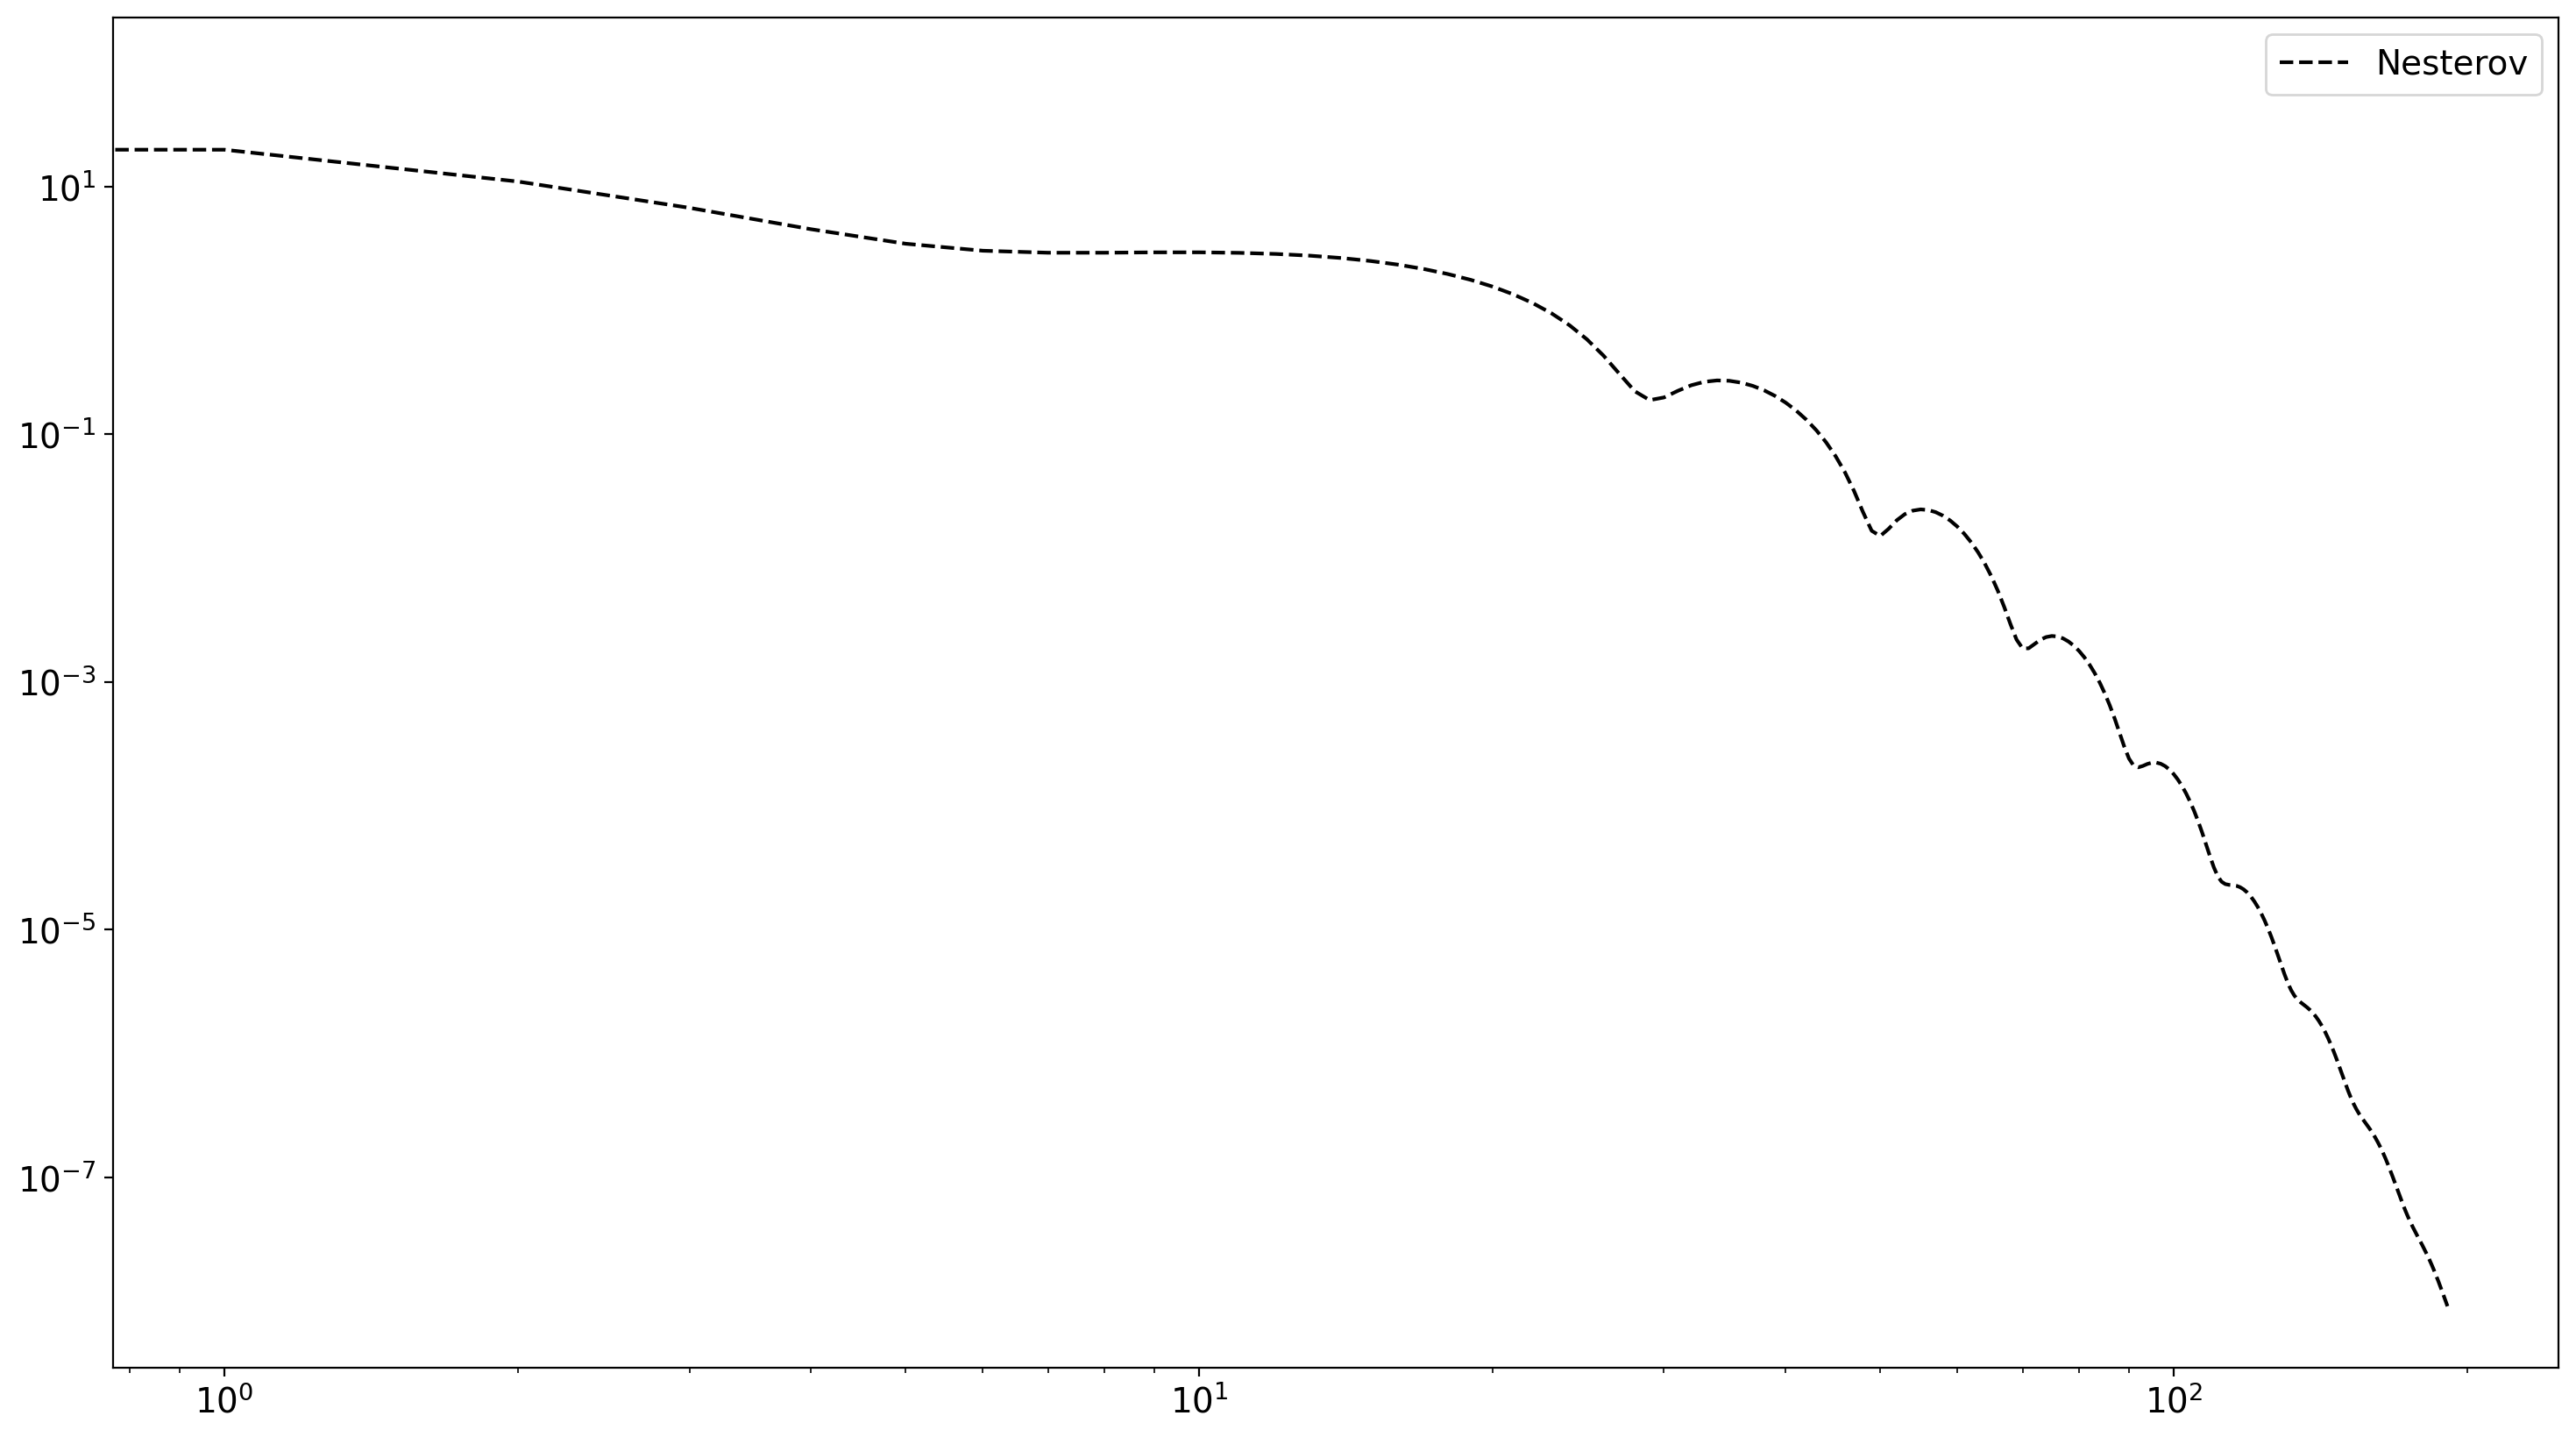

In [6]:
C = 1e2
L = np.max(np.linalg.eig(np.diag(np.ones(X.shape[1])) + C/X.shape[0]*X.T@X/4  ) [0] )
w_init =np.ones(len(X[0]))/10
max_iter = 15000
x_array_const ,f_array_const,grad_array_const = gd_const_step(func,grad_func,w_init ,max_iter= max_iter)
x_array_nesterov ,f_array_nesterov,grad_array_nesterov = gd_nesterov(func,grad_func,w_init ,max_iter=max_iter)
# print(f_array_nesterov - f_array_nesterov[-1])

itter_array_const = np.arange(0 , len(x_array_const) , 1)
itter_array_nesterov = np.arange(0 , len(x_array_nesterov) , 1)

plt.figure(figsize=(18, 10))
# plt.loglog(itter_array_const , grad_array_const ,'k-', ms=16, label='С постоянным шагом')
plt.loglog(itter_array_nesterov , grad_array_nesterov ,'k--', ms=16, label='Nesterov')
plt.legend()
plt.show()

### Экспериментальная оценка зависимости скорости сходимости q от константы C

Невязку мы примерно оценим, считая, что на последней иттерации значение функции очень близко к $f(x_*)$

Также выкинем из массива невязок все нули, так как их число мало по сравнению с числом иттераций, то на линейную аппроксимацию по большому числу точек это не повлияет 

После логарифмирования и линейной аппроксимации мы имеем угол наклона q , который с точки зрения теории должен иметь вид : $q = -c\chi^\alpha$

In [36]:
# НЕВЯЗКА
q_nesterov = []
constant = [10**k for k in range(8)]
# Так как \mu = 0 , то это просто число обусловленности
lipshiz =[]
for C in  constant :
    L = np.max(np.linalg.eig(np.diag(np.ones(X.shape[1])) + C/X.shape[0]*X.T@X/4  ) [0] )
    lipshiz.append(L)
    w_init =np.ones(len(X[0]))/10
    max_iter = 15000
    x_array_nesterov ,f_array_nesterov,grad_array_nesterov = gd_nesterov(func,grad_func,w_init ,max_iter=max_iter)
    r_nesterov = np.abs(f_array_nesterov - f_array_nesterov[-1])
    r_nesterov = r_nesterov[r_nesterov != 0]
    itter_array_nesterov = np.arange(0 , len(r_nesterov) , 1)
    res = np.polyfit(itter_array_nesterov,np.log(r_nesterov), 1)[0]
    q_nesterov.append(res)
    print("Значение q для числа обусловленности  X = %d =" %L,res)
q_nesterov = np.array(q_nesterov)
lipshiz = np.array(lipshiz)


Значение q для числа обусловленности  X = 2 = -2.224082609958994
Значение q для числа обусловленности  X = 11 = -0.6696154734460171
Значение q для числа обусловленности  X = 104 = -0.21265015052508054
Значение q для числа обусловленности  X = 1031 = -0.06415633396244577
Значение q для числа обусловленности  X = 10310 = -0.018299928050883978
Значение q для числа обусловленности  X = 103092 = -0.0055054569822250085
Значение q для числа обусловленности  X = 1030917 = -0.0018971509080313973
Значение q для числа обусловленности  X = 10309170 = -0.00029538719211371473


Прологарифмировав невязку $q$ и число обусловленности $\chi$ приходим к тому ,что в случае $\alpha \approx -0.5$, график имеет ожидаемый линейный вид.

Что с ходится с теорией,где невязка $r_k \le LR^2e^{-\frac{1}{2\sqrt{L/\mu}} k }$

Примерно константа alpha =  -0.5525904068675035


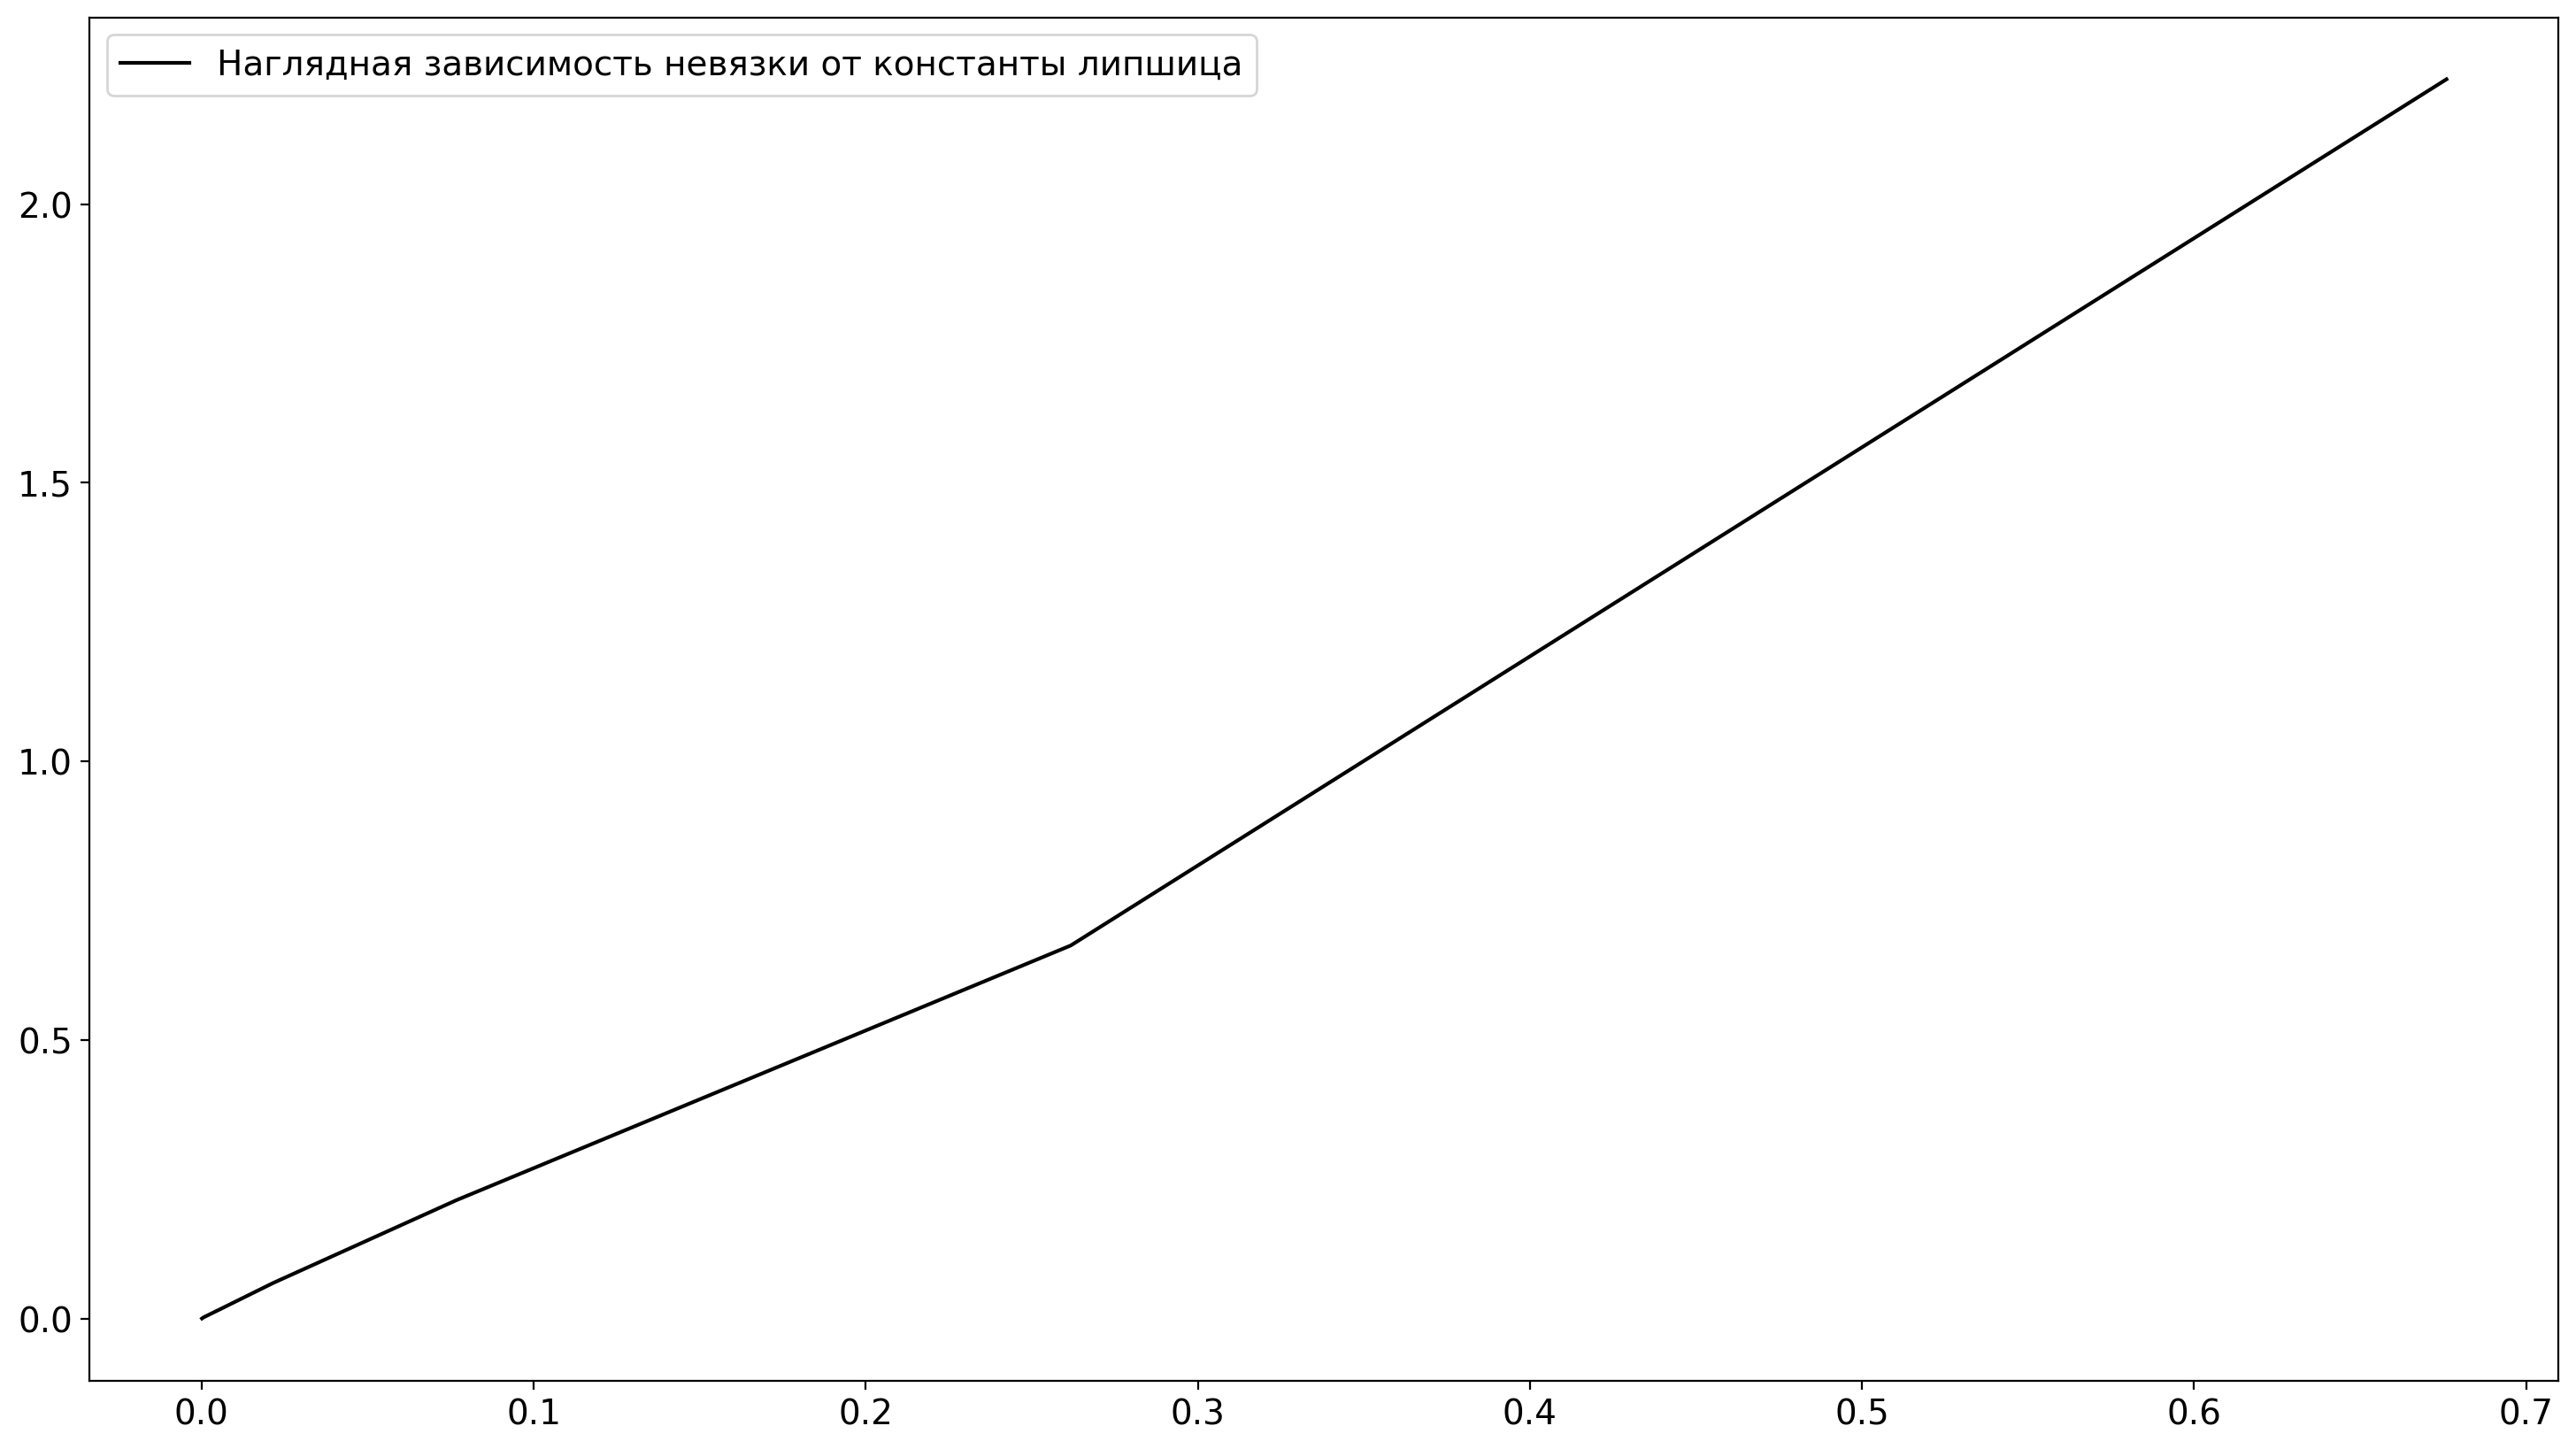

In [38]:
plt.figure(figsize=(18, 10))

aplha = np.polyfit( np.log(lipshiz) , np.log(-q_nesterov), 1)[0]
print("Примерно константа alpha = ",res)
plt.plot(lipshiz**aplha , -q_nesterov ,'k-', ms=16, label='Наглядная зависимость невязки от константы липшица')
plt.legend()
plt.show()